In [21]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import pandas_profiling
import matplotlib.pyplot as plt
import sklearn.metrics as metrics


from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

%config InlineBackend.figure_format = 'svg'

In [15]:
df = pd.read_pickle('../emp_df_clean')
df.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,RandD,accounting,hr,management,marketing,product_mng,support,technical,left
0,0.38,0.53,2,157,3,0,0,1,0,0,0,0,0,0,0,0,1
1,0.80,0.86,5,262,6,0,0,2,0,0,0,0,0,0,0,0,1
2,0.11,0.88,7,272,4,0,0,2,0,0,0,0,0,0,0,0,1
3,0.72,0.87,5,223,5,0,0,1,0,0,0,0,0,0,0,0,1
4,0.37,0.52,2,159,3,0,0,1,0,0,0,0,0,0,0,0,1


#### Feature 1 (last_evaluation * number_project) was best performer in feature engineering therefore progressing with this dataframe

In [16]:
df['int_term_1'] = df.last_evaluation * df.number_project

In [17]:
y = df['left']
X = df.drop(columns=['left', 'last_evaluation', 'number_project'])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.values)
X_test = scaler.transform(X_test.values)

### 1. Random Oversampling

In [22]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

In [23]:
X_resampled_df = pd.DataFrame(X_resampled, columns=X.columns)

KNN

In [25]:
# find out why f1 score gives knn n of 1
ks = range(1,20,2)
param_grid = [{'n_neighbors': ks}]

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc', 
                       verbose=10, n_jobs=-1)
knn_results = knn_grid.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   47.9s remaining:   10.5s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   50.3s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   52.9s finished


In [26]:
knn_results.best_params_

{'n_neighbors': 7}

In [27]:
knn_results.best_score_

0.9845314537525731

SVM

In [52]:
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = {'kernel': kernel}

svc = SVC(probability=True)
svc_grid = GridSearchCV(svc, param_grid, cv=5, scoring='roc_auc', 
                       verbose=10, n_jobs=-1)
svc_results = svc_grid.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  1.4min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  1.6min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  1.9min remaining:   49.6s
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  2.3min remaining:   24.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.6min finished
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [53]:
svc_results.best_estimator_

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [54]:
svc_results.best_params_

{'kernel': 'rbf'}

In [55]:
svc_results.best_score_

0.9728225728593561

Logistic Regression

In [33]:
penalty = ['l2']
C = np.logspace(-3, 1, 100)
param_grid = dict(C=C, penalty=penalty)

logistic = linear_model.LogisticRegression(solver='lbfgs', max_iter=10000)
logistic_grid = GridSearchCV(logistic, param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
logistic_grid.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1969s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1134s.) Setting batch_size=6.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 218 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 308 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 398 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 434 out of 500 | elapsed:    3.5s remaining:    

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.00000e-03, 1.09750e-03, ..., 9.11163e+00, 1.00000e+01]), 'penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [34]:
logistic_grid.best_estimator_

LogisticRegression(C=8.302175681319753, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [35]:
logistic_grid.best_params_

{'C': 8.302175681319753, 'penalty': 'l2'}

In [36]:
logistic_grid.best_score_

0.8142860953967965

Random Forest

In [42]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 100, None],
    'max_features': ['sqrt'], 
    'min_samples_leaf': [1, 2, 5, 10],
    'min_samples_split': [2, 3, 5, 10],
    'n_estimators': [100, 200, 400, 1000]
}

rf = RandomForestClassifier()
rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=10, n_jobs=-1)
rf_grid.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   54.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [50, 100, None], 'max_features': ['sqrt'], 'min_samples_leaf': [1, 2, 5, 10], 'min_samples_split': [2, 3, 5, 10], 'n_estimators': [100, 200, 400, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=10)

In [47]:
rf_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [48]:
rf_grid.best_score_

0.999640993800359

In [49]:
dummy = DummyClassifier()
dummy.fit(X_resampled, y_resampled)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [56]:
print('Best ROC_AUC for knn: %0.4f' % knn_grid.best_score_)
print('Best ROC_AUC for logit: %0.4f' % logistic_grid.best_score_)
print('Best ROC_AUC for svm: %0.4f' % svc_grid.best_score_)
print('Best ROC_AUC for rf: %0.4f' % rf_grid.best_score_)

Best ROC_AUC for knn: 0.9845
Best ROC_AUC for logit: 0.8143
Best ROC_AUC for svm: 0.9728
Best ROC_AUC for rf: 0.9996


In [57]:
from sklearn.calibration import CalibratedClassifierCV
clf = CalibratedClassifierCV(svc)
clf.fit(X_resampled, y_resampled)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change fro

CalibratedClassifierCV(base_estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
            cv='warn', method='sigmoid')

In [58]:
# clf.predict_proba(X_test)

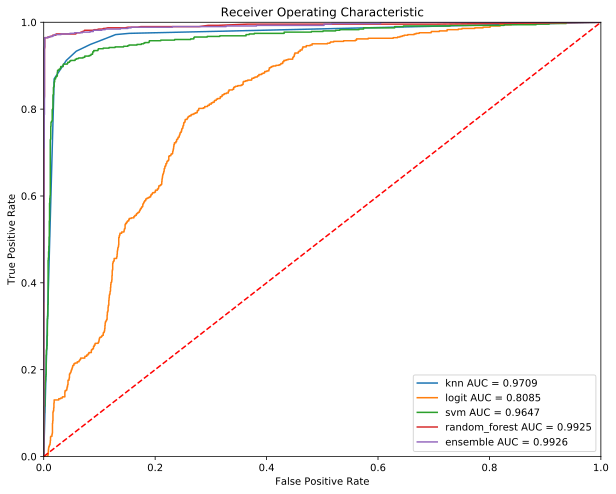

In [59]:
# ROC for all the models
model_list = [knn_grid.best_estimator_, 
              logistic_grid.best_estimator_, 
              svc_grid.best_estimator_, 
              rf_grid.best_estimator_,
              'ensemble']

model_name = ['knn', 'logit', 'svm', 'random_forest', 'ensemble']

# Plot ROC curve for all my models
fig, ax = plt.subplots(figsize=(10,8))
for i, model in enumerate(model_list):
    if model == 'ensemble':
        w1 = 0.10
        w2 = 0.80
        y_pred = (w1*logistic_grid.best_estimator_.predict_proba(X_test)[:,1] 
                  + w2*rf_grid.best_estimator_.predict_proba(X_test)[:,1])
    else:
        # changed form model.predict_proba to clf.predict_proba
        y_pred = list(model.predict_proba(X_test)[:,1])
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = (model_name[i] + ' AUC = %0.4f' % roc_auc))

plt.legend(loc = 'lower right')
plt.title('Receiver Operating Characteristic')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()